## Nasa Turbofan Engine Predictive Maintenance with LSTM

In deep learning, Long Short-Term Memory (LSTM) networks is powerful tool for sequence prediction problems. LSTM is a type of recurrent neural network (RNN) architecture that is well-suited for sequential data, such as time series data generated by sensors in turbofan engines. In this project, we will utilize LSTM to develop an accurate and reliable predictive maintenance model to predict when maintenance is required before a failure occurs, thereby reducing downtime and preventing catastrophic failures.

### 1. Import Library

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from matplotlib import pyplot as plt

### 2. Data Preparation

In [2]:
### Import the pre-proceed dataset of engine FD0001

train_df = pd.read_csv('data/train_fd001_with_rul.csv')
test_df = pd.read_csv('data/test_fd001_with_rul.csv')

cycle = 30

train_df['target'] = np.where(train_df['rul'] <= cycle, 1, 0)
test_df['target'] = np.where(test_df['rul'] <= cycle, 1, 0)

train_df['norm_time_cycles'] = train_df['time_cycles']
test_df['norm_time_cycles'] = test_df['time_cycles']

In [3]:
### Apply mix max normalization

min_max_scaler = preprocessing.MinMaxScaler()

normalization_columns = train_df.columns.difference(['unit_number', 'time_cycles', 'rul', 'target'])

train_df[normalization_columns] = min_max_scaler.fit_transform(train_df[normalization_columns])
test_df[normalization_columns] = min_max_scaler.fit_transform(test_df[normalization_columns])

In [4]:
def generate_sequence(data, sequence_length, sequence_columns):
    vals = data[sequence_columns].values
    row_number = vals.shape[0]
    
    ### Initialize range for start 
    start_range = range(0, row_number - sequence_length)
    
    ### Initialize range for end
    end_range = range(sequence_length, row_number)
    
    ### Start slicing for rows
    for start, stop in zip(start_range, end_range):
        yield vals[start:stop, :]

def generate_label(data, sequence_length):
    vals = data[['target']].values
    row_number = vals.shape[0]
    
    return vals[sequence_length:row_number, :]

In [5]:
selected_columns = ['norm_time_cycles', 'setting_1', 'setting_2', 'setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']

sequence_length = 50

### Generator for sequence data
train_sequence_data = (
    list(generate_sequence(train_df[train_df['unit_number'] == unit_number], sequence_length, selected_columns)) 
        for unit_number in train_df['unit_number'].unique()
)

### Generator for label data
train_label_data = [
    generate_label(train_df[train_df['unit_number'] == unit_number], sequence_length) 
        for unit_number in train_df['unit_number'].unique()
]

### Concatenate all the sequences generated for different units into a single numpy array
### Convert the data type of the array to float32
train_sequence_data = np.concatenate(list(train_sequence_data)).astype(np.float32)

### Concatenate all list of array into a single numpy array
### Convert the data type of the array to float32
train_label_data = np.concatenate(train_label_data).astype(np.float32)

print("Shape of train sequence data: ", train_sequence_data.shape)
print("Shape of train label data: ", train_label_data.shape)

Shape of train sequence data:  (15631, 50, 25)
Shape of train label data:  (15631, 1)


### Model Initialization/ Training/ Evaluation

Every LSTM Layar should be accompanied by dropout layer to prevent overfitting by ignoring randomly selected neurons during training. 20% is common drop out percentage.

In [6]:
number_of_feature = train_sequence_data.shape[2]
number_of_output = train_label_data.shape[1]

### Initialization of model
model = Sequential()

### First layer
### Input shape based on sequence length and number of feature, eg 50, 25.
### 100 unit of neuron
### 'return_sequences = true' process sequences and produce sequences as output to next layer
model.add(LSTM(input_shape = (sequence_length, number_of_feature), units = 100, return_sequences = True))
model.add(Dropout(0.2))

### Second layer
### 50 unit of neuron
### 'return_sequences = false' will not process sequences to last layer
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

### Final layer with activation 'sigmoid'
### Since it is binary classification, the units of layer layer is 1
model.add(Dense(units = number_of_output, activation = 'sigmoid'))

### Model summary detail
model.summary()

### Final setting for training
### loss = 'binary_crossentropy' for classification of  two possible classe, and final layer with 'sigmoid'
### 'adam' optimization updating the model's weights during training based on the calculated gradients of the loss function
### 'accuracy' metric because it is classification tasks
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(train_sequence_data, train_label_data, epochs = 15, batch_size = 200, validation_split = 0.2, verbose = 1)

Epoch 1/15
63/63 [==============================] - 12s 123ms/step - loss: 0.2772 - accuracy: 0.8784 - val_loss: 0.1720 - val_accuracy: 0.9261
Epoch 2/15
63/63 [==============================] - 6s 102ms/step - loss: 0.1184 - accuracy: 0.9520 - val_loss: 0.0685 - val_accuracy: 0.9703
Epoch 3/15
63/63 [==============================] - 7s 111ms/step - loss: 0.0862 - accuracy: 0.9660 - val_loss: 0.0812 - val_accuracy: 0.9687
Epoch 4/15
63/63 [==============================] - 9s 137ms/step - loss: 0.0842 - accuracy: 0.9643 - val_loss: 0.1137 - val_accuracy: 0.9469
Epoch 5/15
63/63 [==============================] - 9s 149ms/step - loss: 0.0823 - accuracy: 0.9650 - val_loss: 0.0677 - val_accuracy: 0.9709
Epoch 6/15
63/63 [==============================] - 9s 139ms/step - loss: 0.0665 - accuracy: 0.9722 - val_loss: 0.0636 - val_accuracy: 0.9754
Epoch 7/15
63/63 [==============================] - 8s 129ms/step - loss: 0.0665 - accuracy: 0.9719 - val_loss: 0.0556 - val_accuracy: 0.9757
Epoch

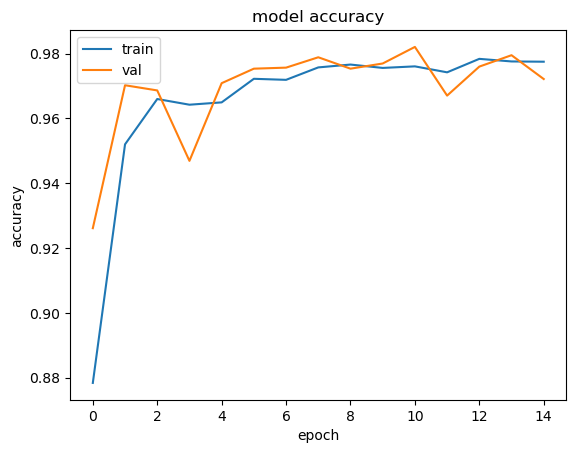

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

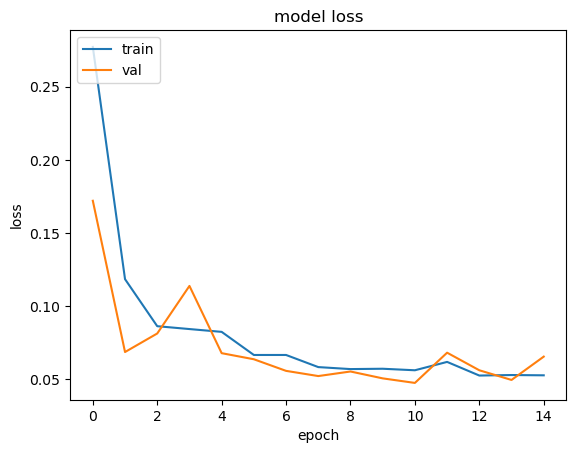

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [10]:
### Training matrix

training_acc_score = model.evaluate(train_sequence_data, train_label_data, verbose = 1, batch_size = 200)

79/79 [==============================] - 4s 46ms/step - loss: 0.0487 - accuracy: 0.9801


489/489 [==============================] - 9s 16ms/step


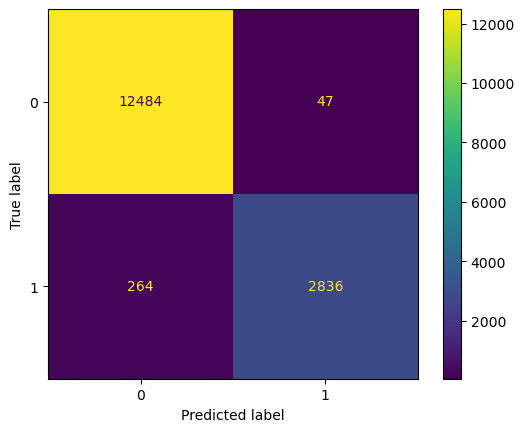

In [11]:
y_pred = np.where(model.predict(train_sequence_data) > 0.5, 1, 0)
y_true = train_label_data

conf_matrix = confusion_matrix(y_true, y_pred)

disp_conf_matrix = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp_conf_matrix.plot()

plt.show()

In [12]:
train_precision = precision_score(y_true, y_pred)
train_recall = recall_score(y_true, y_pred)
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)

print('Accurracy: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(training_acc_score[1], train_precision, train_recall, train_f1))

Accurracy: 0.980103611946106, Precision: 0.9836975372875477, Recall: 0.9148387096774193, F1: 0.9480193882667557


Last sequence data for each engine id in the test data will be used for testing purposes.

In [13]:
test_sequence_data = [
    test_df[test_df['unit_number'] == unit_number][selected_columns].values[-sequence_length:] 
    for unit_number in test_df['unit_number'].unique()
    ### Get selected test data based on engine number with more and equal to 50, otherwise omit 
    if len(test_df[test_df['unit_number'] == unit_number]) >= sequence_length
]

### Convert the list of arrays into a numpy array
test_sequence_data = np.asarray(test_sequence_data).astype(np.float32)

In [14]:
label_filter = [len(test_df[test_df['unit_number'] == unit_number]) >= sequence_length for unit_number in test_df['unit_number'].unique()]

### Group then extract the last value of target
test_label_data = test_df.groupby('unit_number')['target'].nth(-1)[label_filter].values

###  Reshape numpy array to have a single column and convert to 32-bit floating-point data type
test_label_data = test_label_data.reshape(test_label_data.shape[0], 1).astype(np.float32)

print("Shape of train sequence data: ", test_sequence_data.shape)
print("Shape of train label data: ", test_label_data.shape)

Shape of train sequence data:  (93, 50, 25)
Shape of train label data:  (93, 1)


In [15]:
### Testing matrix

test_acc_score = model.evaluate(test_sequence_data, test_label_data, verbose = 1)

3/3 [==============================] - 0s 17ms/step - loss: 0.5325 - accuracy: 0.8710


3/3 [==============================] - 0s 15ms/step


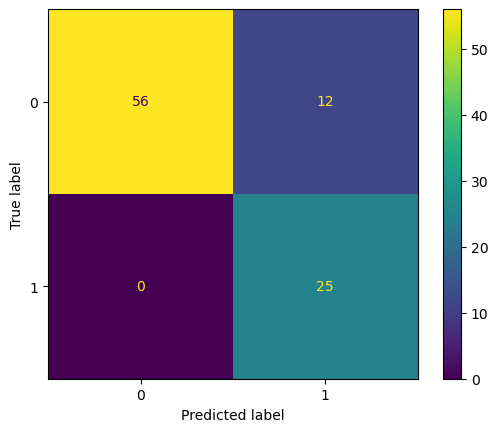

In [16]:
y_pred = np.where(model.predict(test_sequence_data) > 0.5, 1, 0)
y_true = test_label_data

conf_matrix = confusion_matrix(y_true, y_pred)

disp_conf_matrix = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp_conf_matrix.plot()

plt.show()

In [17]:
test_precision = precision_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print('Accurracy: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(test_acc_score[1], test_precision, test_recall, test_f1))

Accurracy: 0.8709677457809448, Precision: 0.6756756756756757, Recall: 1.0, F1: 0.8064516129032258
